El problema de asignacion cuadratica consiste en encontrar la manera optima de asignar un conjunto de instalaciones a ubicaciones de manera que se minimice el costo de transporte. La gran cantidad de asignaciones posibles junto con la dependencia del costo de los flujos y las distancias hace sea un problema extremadamente dificil de resolver en la practica.

El presente estudio busca desarrollar un algoritmo genetico para la resolucion de este problema. Para ello se ha implementado diversos operadores de cruce, de mutacion y de seleccion de padres. Dichos operadores han sido comparados posteriormente para encontrar cual es el que mejor se comporta.

quadratic-assignment-problem-python-notebook.html muestra los resultados obtenidos para la ejecución del jupyter-notebook quadratic-assignment-problem.py puede ser ejecutado despues de haber creado un virtualenv con desde el fichero requirements.txt


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import random
import os

from scipy.stats import linregress
from joblib import Parallel, delayed

In [2]:
# Instancias y soluciones extraidas de http://www.mgi.polymtl.ca/anjos/qaplib/inst.html

FLOWS_DICT = {
    12: np.array([
        [0,90,10,23,43,88,0,0,0,0,0,0],
        [90,0,0,0,0,0,0,0,0,0,0,0],
        [10,0,0,0,0,0,26,16,0,0,0,0],
        [23,0,0,0,0,0,0,0,0,0,0,0],
        [43,0,0,0,0,0,0,0,1,96,29,37],
        [88,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,26,0,0,0,0,0,0,0,0,0],
        [0,0,16,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,1,0,0,0,0,0,0,0],
        [0,0,0,0,96,0,0,0,0,0,0,0],
        [0,0,0,0,29,0,0,0,0,0,0,0],
        [0,0,0,0,37,0,0,0,0,0,0,0],
    ]),
    15: np.array([
        [0,12,86,0,0,0,0,0,0,0,0,0,0,0,0],
        [12,0,0,68,0,0,0,0,0,0,0,0,0,0,0],
        [86,0,0,0,69,0,0,0,0,0,0,0,0,0,0],
        [0,68,0,0,0,34,0,0,0,0,0,0,0,0,0],
        [0,0,69,0,0,0,35,0,0,0,0,0,0,0,0],
        [0,0,0,34,0,0,0,19,0,0,0,0,0,0,0],
        [0,0,0,0,35,0,0,0,2,0,0,0,0,0,0],
        [0,0,0,0,0,19,0,0,0,21,0,0,0,0,0],
        [0,0,0,0,0,0,2,0,0,0,88,0,0,0,0],
        [0,0,0,0,0,0,0,21,0,0,0,79,0,0,0],
        [0,0,0,0,0,0,0,0,88,0,0,0,3,0,0],
        [0,0,0,0,0,0,0,0,0,79,0,0,0,40,0],
        [0,0,0,0,0,0,0,0,0,0,3,0,0,0,77],
        [0,0,0,0,0,0,0,0,0,0,0,40,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,77,0,0],
    ],),
    18: np.array([
        [0,71,40,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [40,0,0,0,27,26,0,0,0,0,0,0,0,0,0,0,0,0],
        [7,0,0,0,0,0,74,20,0,0,0,0,0,0,0,0,0,0],
        [0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,26,0,0,0,0,0,62,0,0,0,0,0,0,0,0,0],
        [0,0,0,74,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
        [0,0,0,20,0,0,0,0,0,0,65,0,0,0,0,0,0,0],
        [0,0,0,0,0,62,0,0,0,0,0,87,33,0,0,0,0,0],
        [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,65,0,0,0,0,0,10,99,0,0,0],
        [0,0,0,0,0,0,0,0,87,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,77,0,0],
        [0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,30,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,77,0,0,0,0,74],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74,0,0],
    ]),
}

DISTANCES_DICT = {
    12: np.array([
        [0,36,54,26,59,72,9,34,79,17,46,95],
        [36,0,73,35,90,58,30,78,35,44,79,36],
        [54,73,0,21,10,97,58,66,69,61,54,63],
        [26,35,21,0,93,12,46,40,37,48,68,85],
        [59,90,10,93,0,64,5,29,76,16,5,76],
        [72,58,97,12,64,0,96,55,38,54,0,34],
        [9,30,58,46,5,96,0,83,35,11,56,37],
        [34,78,66,40,29,55,83,0,44,12,15,80],
        [79,35,69,37,76,38,35,44,0,64,39,33],
        [17,44,61,48,16,54,11,12,64,0,70,86],
        [46,79,54,68,5,0,56,15,39,70,0,18],
        [95,36,63,85,76,34,37,80,33,86,18,0],
    ]),
    15: np.array([
        [0,84,81,10,40,39,5,83,10,78,88,74,88,16,21],
        [84,0,39,67,62,38,3,16,43,47,70,97,4,17,34],
        [81,39,0,53,12,50,98,94,4,16,24,17,20,38,60],
        [10,67,53,0,43,90,84,60,50,43,46,80,53,20,1],
        [40,62,12,43,0,86,18,1,28,14,58,34,2,3,55],
        [39,38,50,90,86,0,58,92,90,62,99,93,64,50,83],
        [5,3,98,84,18,58,0,53,93,69,98,27,19,50,86],
        [83,16,94,60,1,92,53,0,30,35,39,55,25,12,41],
        [10,43,4,50,28,90,93,30,0,16,10,96,7,11,52],
        [78,47,16,43,14,62,69,35,16,0,28,13,97,63,91],
        [88,70,24,46,58,99,98,39,10,28,0,94,91,44,62],
        [74,97,17,80,34,93,27,55,96,13,94,0,48,36,11],
        [88,4,20,53,2,64,19,25,7,97,91,48,0,69,80],
        [16,17,38,20,3,50,50,12,11,63,44,36,69,0,41],
        [21,34,60,1,55,83,86,41,52,91,62,11,80,41,0],
    ],),
    18: np.array([
        [0,13,26,87,39,85,1,56,54,88,36,4,46,90,28,1,2,61],
        [13,0,10,16,71,23,14,76,82,85,12,70,52,51,67,13,17,77],
        [26,10,0,2,82,3,60,70,43,43,11,71,1,14,60,70,57,85],
        [87,16,2,0,12,28,74,40,89,12,86,86,38,21,54,75,55,36],
        [39,71,82,12,0,91,47,1,9,66,60,62,90,19,44,88,58,63],
        [85,23,3,28,91,0,84,64,57,61,45,19,30,64,23,38,77,13],
        [1,14,60,74,47,84,0,36,27,68,61,11,35,94,51,55,26,19],
        [56,76,70,40,1,64,36,0,4,32,36,48,12,16,49,54,96,29],
        [54,82,43,89,9,57,27,4,0,46,81,60,64,50,14,52,30,16],
        [88,85,43,12,66,61,68,32,46,0,43,95,57,88,21,91,83,50],
        [36,12,11,86,60,45,61,36,81,43,0,74,76,18,44,40,36,23],
        [4,70,71,86,62,19,11,48,60,95,74,0,66,61,68,81,17,80],
        [46,52,1,38,90,30,35,12,64,57,76,66,0,94,27,11,43,50],
        [90,51,14,21,19,64,94,16,50,88,18,61,94,0,97,73,55,58],
        [28,67,60,54,44,23,51,49,14,21,44,68,27,97,0,63,99,35],
        [1,13,70,75,88,38,55,54,52,91,40,81,11,73,63,0,12,46],
        [2,17,57,55,58,77,26,96,30,83,36,17,43,55,99,12,0,49],
        [61,77,85,36,63,13,19,29,16,50,23,80,50,58,35,46,49,0],
    ])
    
}

ABSOLUTE_MIN_DICT = {
    12: 9742,
    15: 9504,
    18: 11098,
}

BEST_SOLUTION_DICT = {
    12: np.array([5 , 7,  1, 10, 11,  3,  4,  2,  9,  6, 12,  8]),
    15: np.array([13,  2,  5,  7,  8,  1, 14,  6,  4,  3, 15,  9, 12, 11, 10]),
    18: np.array([3, 13, 6, 4, 18, 12, 10, 5, 1, 11, 8, 7, 17, 14, 9, 16, 15, 2]),
}

In [3]:
# Parametros de configuración general
TO_REPEAT_TIMES_PER_CONFIG = 50 # veces que se va a repetir para cada configuración. Deberian ser 20 minimo segun el enunciado de la práctica
N_ITER_PARADA = 100 # numero de iteraraciones sin mejorar para el criterio de parada
N_COMPLEJIDAD_INSTANCIA = 12 # Complejidad de la instancia a usar. (Dimensiones de las matrices de distancias y flujos)

# Constantes derivadas de N_COMPLEJIDAD_INSTANCIA:
FLOWS = FLOWS_DICT[N_COMPLEJIDAD_INSTANCIA]
DISTANCES = DISTANCES_DICT[N_COMPLEJIDAD_INSTANCIA]
ABSOLUTE_MIN = ABSOLUTE_MIN_DICT[N_COMPLEJIDAD_INSTANCIA]
BEST_SOLUTION = BEST_SOLUTION_DICT[N_COMPLEJIDAD_INSTANCIA]

In [4]:
def get_cost(np_array):
    """
    Función objetivo
    
    Dado un np.array representado una permutacion devuelve el coste
    """
    assert(isinstance(np_array, np.ndarray))
    to_return = 0
    for i in range(len(np_array)):
        for j in range(len(np_array)):
            to_return = to_return + FLOWS[i][j] * DISTANCES[np_array[i]][np_array[j]] 
    return to_return

In [5]:
def is_matrix_symmetric(np_matrix, rtol=1e-05, atol=1e-08):
    """
    Devuelve True si la matriz <np_matrix> es simetrica
    """
    return np.allclose(np_matrix, np_matrix.T, rtol=rtol, atol=atol)


# Comprobaciones iniciales en las matrices FLOWS y DISTANCES
for n in FLOWS_DICT:
    
    # Los elementos en la diagonal deben ser 0
    assert(np.count_nonzero(np.diag(FLOWS_DICT[n])) == 0) 
    assert(np.count_nonzero(np.diag(DISTANCES_DICT[n])) == 0) 

    # Las matrices deben ser simetricas
    assert(is_matrix_symmetric(FLOWS_DICT[n])) 
    assert(is_matrix_symmetric(DISTANCES_DICT[n]))

    # Ambas matrices deben tener las mismas dimensiones
    assert(len(FLOWS_DICT[n]) == len(DISTANCES_DICT[n]))
    
    
# El coste de la mejor solucion debe coincidir con la solucion minima posible
assert(get_cost(BEST_SOLUTION - 1) == ABSOLUTE_MIN) # Hay que restarle 1 porque numpy empieza los indices desde 0

In [6]:
def is_valid_permutation(np_array):
    """
    Devuelve True si el array representa una permutación valida. False en caso contrario.
    """
    return min(np_array) == 0 and max(np_array + 1) == len(np_array) == len(set(np_array))

In [7]:
def get_random_population(population_size, n):
    """
    Devuelve una lista de longitud <population_size> cuyos elementos son permutaciones aleatorias de longitud <n>
    """
    to_return = []
    for i in range(population_size):
        to_return.append(np.random.permutation(n))
    # TODO ? comprobar si hay alguna repetida?
    return to_return

In [8]:
# Operadores mutación

def mutate_swap(np_array):
    """
    Mutación por intercambio
    """
    first, second = np.random.choice(range(len(np_array)), 2, replace=False)
    aux = np_array[first]
    np_array[first] = np_array[second]
    np_array[second] = aux 
    assert(is_valid_permutation(np_array))

def mutate_inversion(np_array):
    """
    Mutación por inversión
    """
    start, end = sorted(np.random.choice(range(len(np_array)), 2, replace=False))
    np_array[start:end + 1] = np_array[start:end + 1][::-1]
    assert(is_valid_permutation(np_array))
    
def mutate_scramble(np_array):
    """
    Mutación scramble
    """
    start, end = sorted(np.random.choice(range(len(np_array)), 2, replace=False))
    to_shuffle = np_array[start:end+1]
    np.random.shuffle(to_shuffle)
    np_array[start:end + 1] = to_shuffle
    assert(is_valid_permutation(np_array))
    
def mutate_insertion(np_array):
    """
    Mutación por inserción
    """
    start, end = sorted(np.random.choice(range(len(np_array)), 2, replace=False))
    aux = np_array[end]
    for i in range(end, start, -1):
        np_array[i] = np_array[i-1]
    np_array[start + 1] = aux
    assert(is_valid_permutation(np_array))


In [9]:
# Operadores Crossover

def get_crossover_order_aux(np_array_1, np_array_2, start, end):
    """
    Función auxiliar para el crossover order
    """
    # Inicializamos un np array hijo de la misma longitud de los padres pero con todos los elementos -1
    to_return_np_array = np.repeat(-1, len(np_array_1)) 
    # Al hijo le ponemos la informacion del padre1 entre start y end
    to_return_np_array[start:end] = np_array_1[start:end]

    # Todos los valores de la permutacion que aun no esten en el hijo, los cogeremos del padre2 en orden
    pending_to_add_elements = [i for i in np_array_2[end:] if i not in to_return_np_array] + [i for i in np_array_2[0:end] if i not in to_return_np_array]

    # Añadimos esos valores al hijo
    for i in range(end, len(np_array_1)):
        to_return_np_array[i] = pending_to_add_elements.pop(0)
    for i in range(0, start):
        to_return_np_array[i] = pending_to_add_elements.pop(0)
    return to_return_np_array
    
def get_crossover_order(to_crossover_parents):
    """
    Crossover order
    """
    
    parent_1_index, parent_2_index = sorted(np.random.choice(range(len(to_crossover_parents)), 2, replace=False))
    np_array_1, np_array_2 = to_crossover_parents[parent_1_index], to_crossover_parents[parent_2_index] # Padre1 y padre2

    assert(np.array_equal(np.sort(np_array_1), np.sort(np_array_2))) # Comprobamos que padre1 y padre2 es el mismo tipo de permutacion
    
    start, end = sorted(np.random.choice(range(len(np_array_1)), 2, replace=False))
    
    to_return_np_array_1 = get_crossover_order_aux(np_array_1, np_array_2, start, end)
    to_return_np_array_2 = get_crossover_order_aux(np_array_2, np_array_1, start, end)
        
    assert(np.array_equal(np.sort(to_return_np_array_1), np.sort(np_array_2))) # Comprobamos que es una permutacion correcta
    assert(np.array_equal(np.sort(to_return_np_array_2), np.sort(np_array_2))) # Comprobamos que es una permutacion correcta
    return [to_return_np_array_1, to_return_np_array_2]


def get_multiparent_crossover(to_crossover_parents):
    """
    Mutiparent crossover
    Es una version del algoritmo explicado aqui https://www.sciencedirect.com/science/article/pii/S0307904X12003617
    """    
    n = len(to_crossover_parents[0])
    parent_indexes = sorted(np.random.choice(range(len(to_crossover_parents)), n, replace=True))
    parents = [to_crossover_parents[i] for i in parent_indexes]
    # print(parents)
    elements = []
    for i in range(len(to_crossover_parents[0])):
        # print(i)
        to_choose_from = list(range(n))
        # print(to_choose_from)
        while True:
            choosen_parent = np.random.choice(to_choose_from)
            to_append = parents[choosen_parent][i]
            if to_append not in elements:
                # print('elements {}'.format(elements))
                elements.append(to_append)
                # print('elements {}'.format(elements))
                break
            else:
                if len(to_choose_from)== 1:
                    to_append = np.random.choice([element for element in list(range(n)) if element not in elements] )
                    elements.append(to_append)
                    # print("añado {} a la posicion {}".format(to_append, i))
                    break
                    # print('to_choose_from {}'.format(to_choose_from))
                to_choose_from.remove(choosen_parent)
                # print('to_choose_from {}'.format(to_choose_from))

    to_return_child = np.array(elements)
    assert(is_valid_permutation(to_return_child))
    # print(to_return_child)
    return [to_return_child,]

In [10]:
# Seleccion de padres

def get_parent_selection_elitist(np_arrays, proportion=0.5):
    """
    Selección de padres elitista
    """
    costs = []
    for element in np_arrays:
        costs.append(get_cost(element))

    sorted_indexs = np.argsort(costs) #indices de menor a mayor

    sorted_indexs = sorted_indexs[:int(len(np_arrays) * proportion)]
    coste_minimo = costs[sorted_indexs[0]]

    return [np_arrays[i] for i in sorted_indexs], coste_minimo, np.mean(costs)

def get_parent_selection_proportional(np_arrays, proportion=0.5):
    """
    Selección de padres proporcional
    """
    cuantos = int(len(np_arrays) * proportion)
        
    costs = []
    for element in np_arrays:
        costs.append(get_cost(element))
    
    coste_minimo = min(costs)

    weights = [1/cost for cost in costs] # invertimos porque tenemos que minimizar 
    return random.choices(np_arrays, weights=weights, k=cuantos), coste_minimo, np.mean(costs)


def get_repeated_2_vectors(a, b):
    """
    Función auxiliar para la selección de padres por torneo
    """
    result = False
    for i in range (len(b)):
        repeated = True
        for j in range(len(a)):
            if a[j]!= b[i][j]:
                repeated = False
        if repeated == True:
            result = True
    return result

def get_repeated_int(a, b):
    """
    Función auxiliar para la selección de padres por torneo
    """
    result = False
    for i in range (len(b)):
        repeated = True
        if a!= b[i]:
            repeated = False
        if repeated == True:
            result = True
    return result


def get_parent_selection_tourney(np_arrays, proportion=0.5):
    """
    Selección de padres por torneo
    """
    k = 2
    final_indexs=[]
    to_check=[]
    
   
    for j in range(int(len(np_arrays) * proportion)):
        index=[]
        costs=[]
        #min_cost=[]
        for i in range(k):
            new_index = random.randrange(0,len(np_arrays))
            if (len(index) > 0 or len(to_check)) :
                
                while (get_repeated_int(new_index, index)== True or get_repeated_int(new_index,to_check)==True):
                    #comprueba que los individuos que compiten no esten repetidos, ni que se repitan los finalmente seleccionados
                    new_index = random.randrange(0,len(np_arrays))
                        
            index.append(new_index)
        

        for l in range(k):
            costs.append(get_cost(np_arrays[index[l]]))
            #min_cost.append(min(costs))
        to_check.append(index[costs.index(min(costs))])
      
    return [np_arrays[i] for i in to_check], min(costs), np.mean(costs)

In [11]:
# Criterios de parada

def parada_slope(min_costs):
    """
    Criterio de parada evaluando la pendiente en los últimos n elementos
    """
    if len(min_costs) > N_ITER_PARADA:
        slope, intercept, r_value, p_value, std_err = linregress(range(N_ITER_PARADA), min_costs[-N_ITER_PARADA:])

        if len(min_costs) > 1:
            if abs(slope) < 1:
                return True
    return False

def is_parada_umbral_coste(min_costs):
    """
    Devuelve True si <min_costs> esta por debajo de un umbral de coste
    """
    umbral_coste = ABSOLUTE_MIN # TODO hacer parametro
    if min_costs[-1] <= umbral_coste:
        return True
    return False

def is_parada_n_iteraciones_sin_mejorar(min_costs):
    """
    Devuelve True si <min_costs> lleva n iteraciones sin mejorar
    """
    if len(min_costs) > N_ITER_PARADA:
          if min_costs[-1] >= min_costs[-N_ITER_PARADA]:
            return True
    return False


def is_parada_combinacion_slope(min_costs):
    """
    Combinación de is_parada_umbral_coste y parada_slope
    """
    return is_parada_umbral_coste(min_costs) or parada_slope(min_costs)


def is_parada_combinacion(min_costs):
    """
    Combinación de is_parada_umbral_coste y is_parada_n_iteraciones_sin_mejorar
    """
    return is_parada_umbral_coste(min_costs) or is_parada_n_iteraciones_sin_mejorar(min_costs)
    

In [12]:
def get_reduction(np_arrays):
    """
    Controla la reducción
    """
    costs = []
    for element in np_arrays:
        costs.append(get_cost(element))
    
    to_remove = costs.index(max(costs))
    np_arrays.pop(to_remove)
    return np_arrays

In [13]:
class GeneticAlgorithm:
    
    def __init__(self, 
                 
                 crossover_f, 
                 to_crossover_parents_selection_f, 
                 parada_method_f,
                 mutation_f, 
                 mutation_probability,
                 parents_to_select_to_crossover_proportion,
                 is_use_reduction,
                 
                 initial_population):

        self.repeat_times = TO_REPEAT_TIMES_PER_CONFIG
        self.crossover_f = crossover_f 
        self.to_crossover_parents_selection_f = to_crossover_parents_selection_f
        self.parada_method_f = parada_method_f
        self.mutation_f = mutation_f
        self.mutation_probability = mutation_probability
        self.parents_to_select_to_crossover_proportion = parents_to_select_to_crossover_proportion
        self.is_use_reduction = is_use_reduction
        self.initial_population = initial_population
    
        self.description = "{} {} {} parents_to_select_to_crossover_proportion={} mutation_probability={} is_use_reduction={} poblacion_inicial_tamaño={}".format(
                                                crossover_f.__name__, 
                                                to_crossover_parents_selection_f.__name__,
                                                mutation_f.__name__, 
                                                                                                    
                                                parents_to_select_to_crossover_proportion,
                                                mutation_probability,
                                                is_use_reduction,
            
                                                len(initial_population)
                                               )

    
    def start(self):
        to_return = []
        for i in range(self.repeat_times): # para cada configuracion vamos a repetir al menos 20 veces, como dice el enunciado de la practica
            print('{} repeticiones de {} '.format(i+1, self.repeat_times))
            self.population = self.initial_population.copy()
            start_time = time.time()
            min_costs = []
            mean_costs = []
            while True:

                to_crossover_parents, cost, cost_mean = self.to_crossover_parents_selection_f(self.population, self.parents_to_select_to_crossover_proportion) # Selecionamos los mejores padres
                min_costs.append(cost)
                mean_costs.append(cost_mean)

                if self.parada_method_f(min_costs):
                    break

                new_population = to_crossover_parents

                while len(new_population) < len(self.population):

                    hijos = self.crossover_f(to_crossover_parents) # Cruce
                    
                    if self.is_use_reduction:
                        if len(min_costs) > 10:
                            new_population = get_reduction(new_population)
                    
                    for hijo in hijos:
                        if np.random.uniform() <= self.mutation_probability:
                            self.mutation_f(hijo) # Mutación
                        new_population.append(hijo)

                self.population = new_population
                
            run_time = time.time() - start_time
            
            to_return.append({"min_costs": min_costs, "run_time": run_time , "mean_costs": mean_costs})
        
        return  to_return
    

In [14]:
def show_plot(costs, ylabel):
    """
    Dibuja un gráfico de la evolución de los costes a lo largo de las generaciones
    """
    pd.DataFrame(costs).T.plot(legend=False, figsize=((10, 7)))
    plt.xlabel("Generación", fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.tick_params(labelsize=20)
    plt.show()

    
def print_summary_from_ga_results(ga_results, ga):
    """
    Imprime información detallada dado un resultado de la ejecución del algoritmo genetico para una configuracion determinada
    ga_results es una lista de dicts
    """
    
    print("---> Resultados para: {}".format(ga.description))

        
    n = len(ga_results) # número de ejecuciones repetidas
    
    encontrado_count = 0
    encontrado_tiempos = []
    encontrado_min_costs = []
    encontrado_mean_costs = []
    
    todos_min_costs = []
    todos_mean_costs = []
    
    for single_execution_ga_result in ga_results:
        
        min_costs = single_execution_ga_result['min_costs'] # lista de n listas
        mean_costs = single_execution_ga_result['mean_costs'] # lista de n listas
        run_time = single_execution_ga_result['run_time'] # lista de n listas
    
        if min_costs[-1] == ABSOLUTE_MIN:
            # han encontrado el minimo
            encontrado_count = encontrado_count + 1
            encontrado_tiempos.append(run_time)
            encontrado_min_costs.append(min_costs)
            encontrado_mean_costs.append(mean_costs)
        todos_min_costs.append(min_costs)
        todos_mean_costs.append(mean_costs)
    
    print('Han encontrado el mínimo {} de {}, el {} %'.format(encontrado_count, n, encontrado_count * 100 / n))
    if len(encontrado_tiempos) > 0:
        print('Tiempo medio de las ejecuciones que han encontrado el minimo: {} segundos '.format(np.mean(encontrado_tiempos)))
    
    # TODO añadir titulo a los ejes
    
    if len(encontrado_min_costs) > 0 :
        
        show_plot(encontrado_min_costs, "Coste mínimo")
        show_plot(encontrado_mean_costs, "Coste medio")
        
    show_plot(todos_min_costs, "Coste mínimo")
    show_plot(todos_mean_costs, "Coste medio")  
    

In [15]:
grid_gas = []

#VERSION corta del grid    
for grid_population_size in range(50, 100, 50):
    # Usamos la misma poblacion inicial para una mejor comparacion entre los operadores
    grid_initial_population = get_random_population(grid_population_size, len(FLOWS)) 
    for grid_mutate_method_f in [mutate_swap, ]:
        for grid_parent_selection_method_f in [get_parent_selection_elitist, ]:
            for grid_mutation_probability in [x / 10.0 for x in range(9, 11, 1)]:
                for grid_parents_to_select_to_crossover_proportion in [x / 10.0 for x in range(3, 5, 2)]:
                    for grid_is_use_reduction in [False, ]:
                        genetic_algorithm = GeneticAlgorithm(
                            crossover_f = get_multiparent_crossover, 
                            to_crossover_parents_selection_f = grid_parent_selection_method_f, 
                            parada_method_f = is_parada_combinacion,
                            mutation_f = grid_mutate_method_f, 
                            mutation_probability = grid_mutation_probability,
                            parents_to_select_to_crossover_proportion = grid_parents_to_select_to_crossover_proportion,
                            initial_population = grid_initial_population,
                            is_use_reduction=grid_is_use_reduction
                        )

                        grid_gas.append(genetic_algorithm)

2 configuraciones a ejecutar

1 de 2 configuraciones

1 repeticiones de 50 
2 repeticiones de 50 
3 repeticiones de 50 
4 repeticiones de 50 
5 repeticiones de 50 
6 repeticiones de 50 
7 repeticiones de 50 
8 repeticiones de 50 
9 repeticiones de 50 
10 repeticiones de 50 
11 repeticiones de 50 
12 repeticiones de 50 
13 repeticiones de 50 
14 repeticiones de 50 
15 repeticiones de 50 
16 repeticiones de 50 
17 repeticiones de 50 
18 repeticiones de 50 
19 repeticiones de 50 
20 repeticiones de 50 
21 repeticiones de 50 
22 repeticiones de 50 
23 repeticiones de 50 
24 repeticiones de 50 
25 repeticiones de 50 
26 repeticiones de 50 
27 repeticiones de 50 
28 repeticiones de 50 
29 repeticiones de 50 
30 repeticiones de 50 
31 repeticiones de 50 
32 repeticiones de 50 
33 repeticiones de 50 
34 repeticiones de 50 
35 repeticiones de 50 
36 repeticiones de 50 
37 repeticiones de 50 
38 repeticiones de 50 
39 repeticiones de 50 
40 repeticiones de 50 
41 repeticiones de 50 
42 repeticio

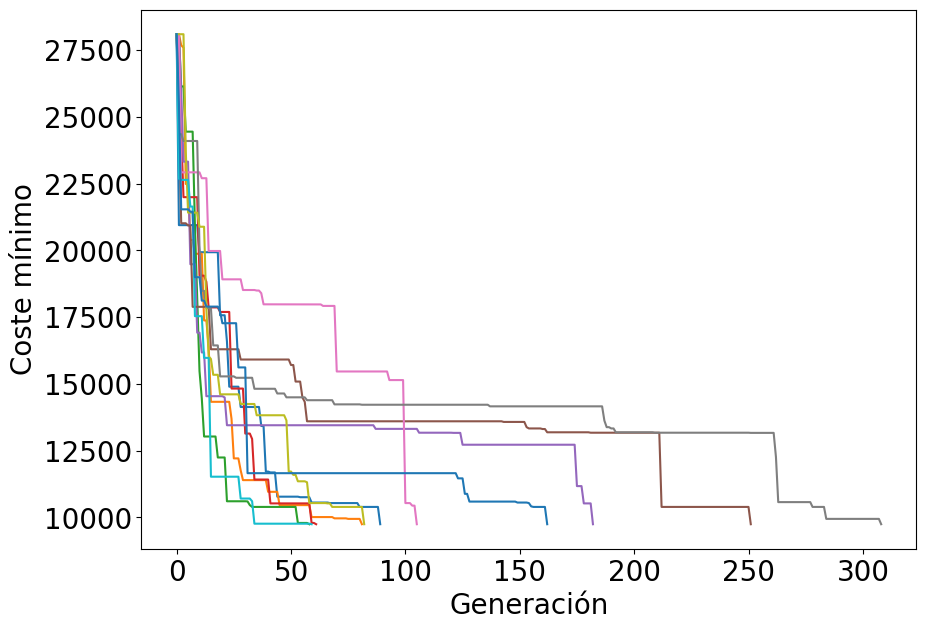

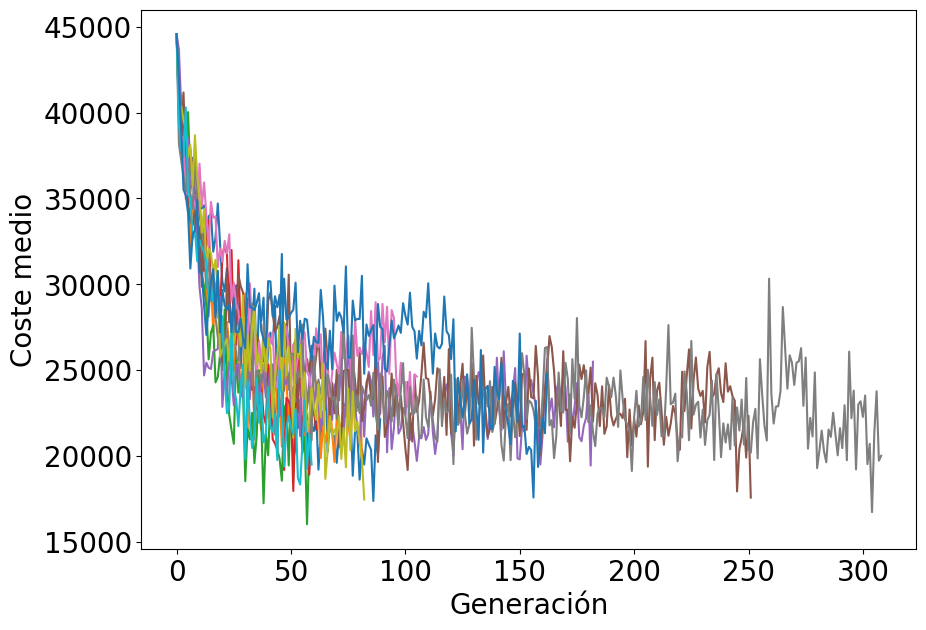

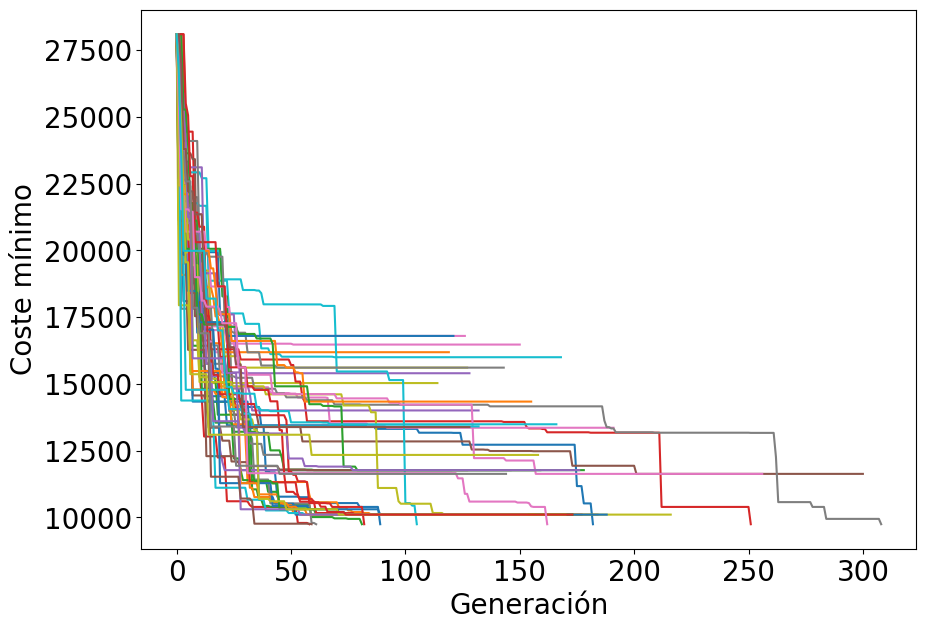

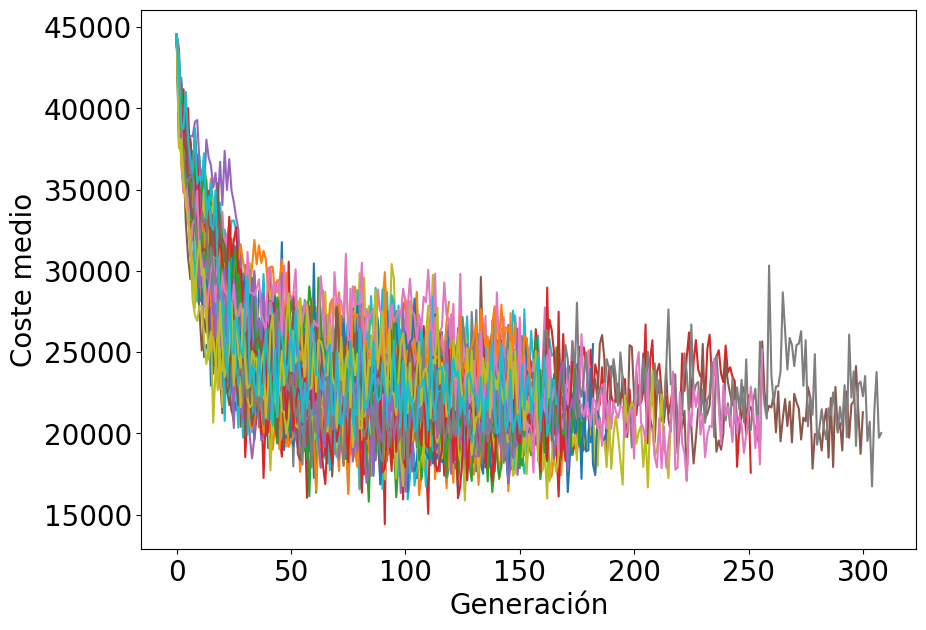



2 de 2 configuraciones

1 repeticiones de 50 
2 repeticiones de 50 
3 repeticiones de 50 
4 repeticiones de 50 
5 repeticiones de 50 
6 repeticiones de 50 
7 repeticiones de 50 
8 repeticiones de 50 
9 repeticiones de 50 
10 repeticiones de 50 
11 repeticiones de 50 
12 repeticiones de 50 
13 repeticiones de 50 
14 repeticiones de 50 
15 repeticiones de 50 
16 repeticiones de 50 
17 repeticiones de 50 
18 repeticiones de 50 
19 repeticiones de 50 
20 repeticiones de 50 
21 repeticiones de 50 
22 repeticiones de 50 
23 repeticiones de 50 
24 repeticiones de 50 
25 repeticiones de 50 
26 repeticiones de 50 
27 repeticiones de 50 
28 repeticiones de 50 
29 repeticiones de 50 
30 repeticiones de 50 
31 repeticiones de 50 
32 repeticiones de 50 
33 repeticiones de 50 
34 repeticiones de 50 
35 repeticiones de 50 
36 repeticiones de 50 
37 repeticiones de 50 
38 repeticiones de 50 
39 repeticiones de 50 
40 repeticiones de 50 
41 repeticiones de 50 
42 repeticiones de 50 
43 repeticiones d

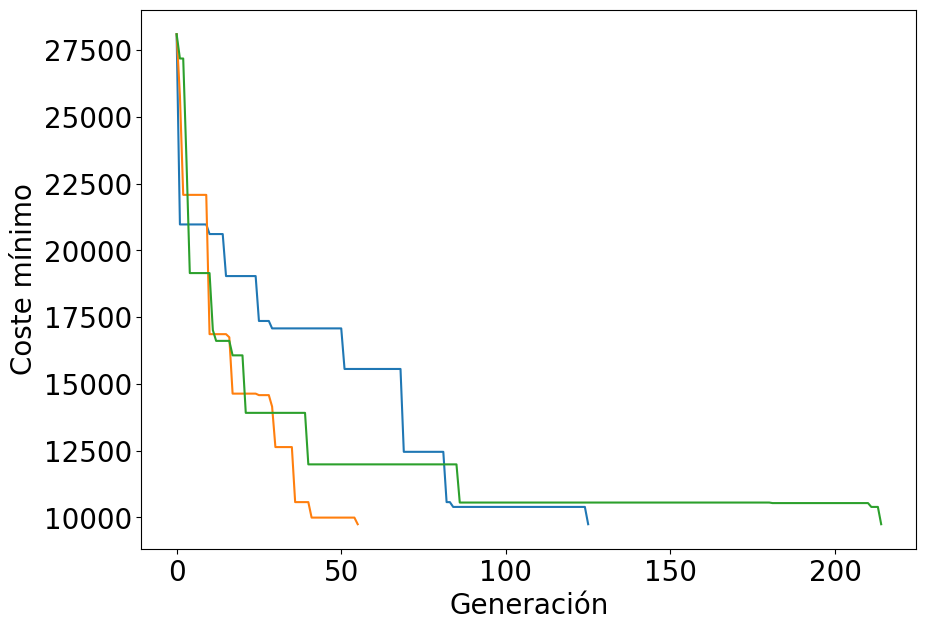

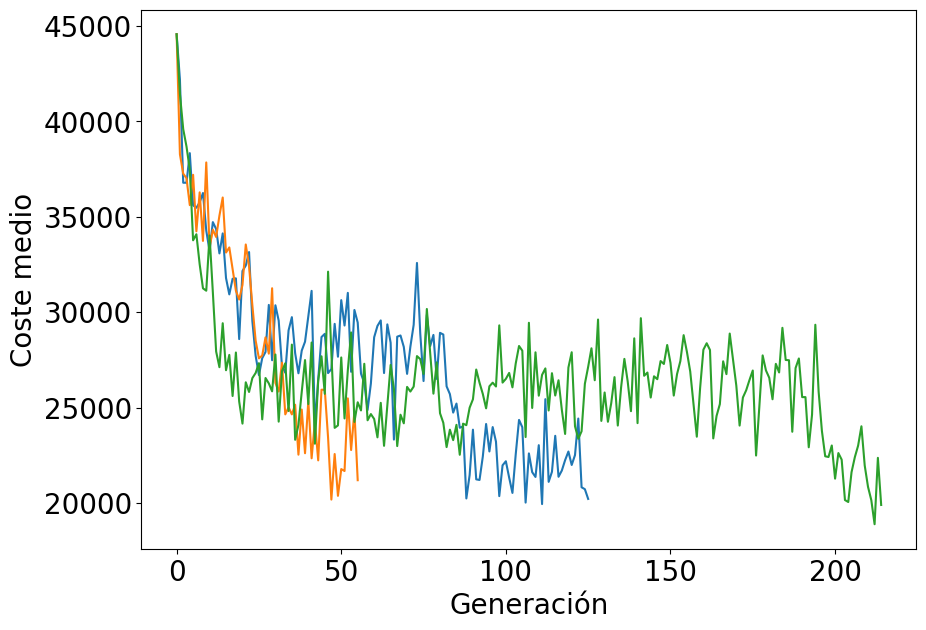

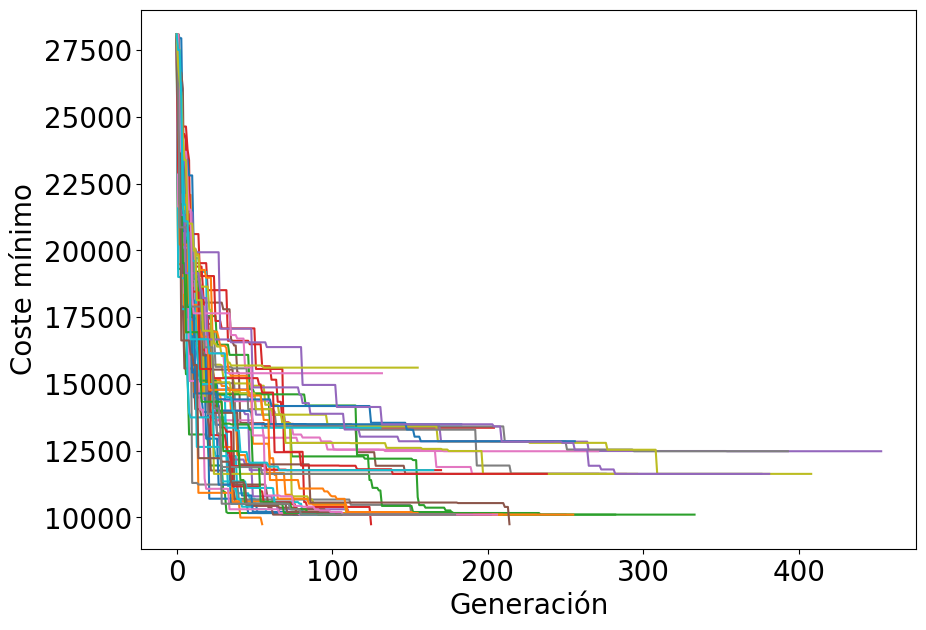

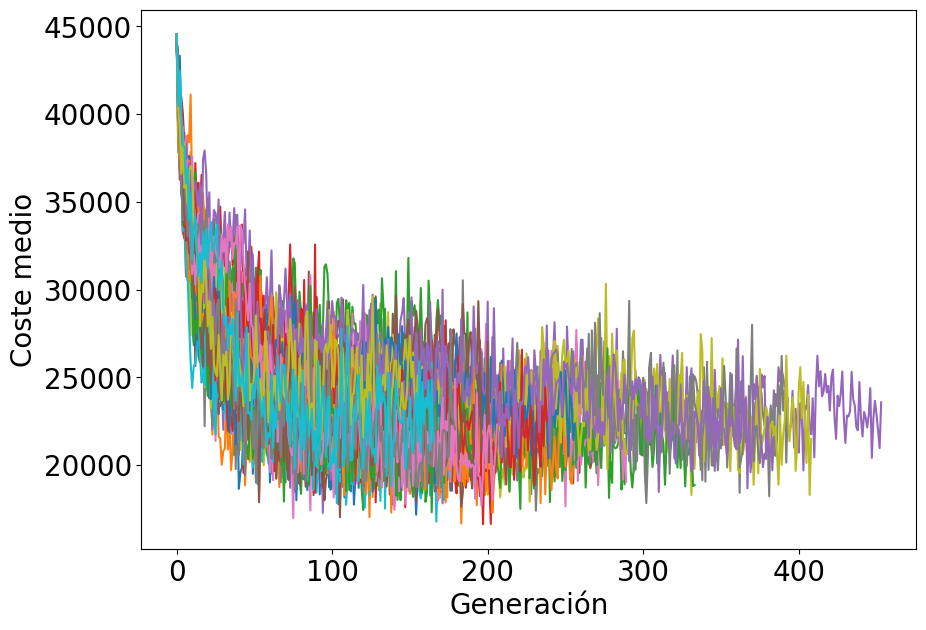

In [16]:
def start_ga(ga):
    return ga.start(), ga

print('{} configuraciones a ejecutar'.format(len(grid_gas)))
print('')
for idx, ga in enumerate(grid_gas):
    print('{} de {} configuraciones'.format(idx+1, len(grid_gas)))
    print('')
    print_summary_from_ga_results(ga.start(), ga)
    print('')
    print('')

In [17]:
# #VERSION media del grid    
# for grid_population_size in range(50, 100, 250):
#     # Usamos la misma poblacion inicial para una mejor comparacion entre los operadores
#     grid_initial_population = get_random_population(grid_population_size, len(FLOWS)) 
#     for grid_mutate_method_f in [mutate_swap,mutate_inversion, mutate_scramble, mutate_insertion ]:
#         for grid_parent_selection_method_f in [get_parent_selection_elitist, get_parent_selection_tourney ]:
#             for grid_crossover_f in [get_multiparent_crossover, get_crossover_order]:
#                 for grid_mutation_probability in [x / 10.0 for x in range(5, 11, 1)]:
#                     for grid_parents_to_select_to_crossover_proportion in [x / 10.0 for x in range(1, 5, 2)]:

#                         genetic_algorithm = GeneticAlgorithm(
#                             crossover_f = grid_crossover_f, 
#                             to_crossover_parents_selection_f = grid_parent_selection_method_f, 
#                             parada_method_f = is_parada_combinacion,
#                             mutation_f = grid_mutate_method_f, 
#                             mutation_probability = grid_mutation_probability,
#                             parents_to_select_to_crossover_proportion = grid_parents_to_select_to_crossover_proportion,
#                             initial_population = grid_initial_population,
#                         )
#                         print('Ejecutando {}....'.format(genetic_algorithm.description))
#                         genetic_algorithm_result_dict = genetic_algorithm.start()

#                         print_summary_from_ga_results(genetic_algorithm_result_dict, genetic_algorithm)

#                         print('')
#                         print('')

In [18]:
# #VERSION corta del grid    
# for grid_population_size in range(50, 100, 50):
#     # Usamos la misma poblacion inicial para una mejor comparacion entre los operadores
#     grid_initial_population = get_random_population(grid_population_size, len(FLOWS)) 
#     for grid_mutate_method_f in [mutate_swap, ]:
#         for grid_parent_selection_method_f in [get_parent_selection_elitist, ]:
#             for grid_mutation_probability in [x / 10.0 for x in range(9, 11, 1)]:
#                 for grid_parents_to_select_to_crossover_proportion in [x / 10.0 for x in range(3, 5, 2)]:
                    
#                     genetic_algorithm = GeneticAlgorithm(
#                         crossover_f = get_multiparent_crossover, 
#                         to_crossover_parents_selection_f = grid_parent_selection_method_f, 
#                         parada_method_f = is_parada_combinacion,
#                         mutation_f = grid_mutate_method_f, 
#                         mutation_probability = grid_mutation_probability,
#                         parents_to_select_to_crossover_proportion = grid_parents_to_select_to_crossover_proportion,
#                         initial_population = grid_initial_population,
#                     )

#                     genetic_algorithm_result_dict = genetic_algorithm.start()
                    
#                     print_summary_from_ga_results(genetic_algorithm_result_dict, genetic_algorithm)

#                     print('')
#                     print('')

In [19]:
# #VERSION paralela del grid. Kaggle solo permite 4 cores
# gas = []
# # copiar y pegar un grid anterior a continuacion

# for grid_population_size in range(50, 100, 250):
#     # Usamos la misma poblacion inicial para una mejor comparacion entre los operadores
#     grid_initial_population = get_random_population(grid_population_size, len(FLOWS)) 
#     for grid_mutate_method_f in [mutate_swap,mutate_inversion, mutate_scramble, mutate_insertion ]:
#         for grid_parent_selection_method_f in [get_parent_selection_elitist, get_parent_selection_tourney ]:
#             for grid_crossover_f in [get_multiparent_crossover, get_crossover_order]:
#                 for grid_mutation_probability in [x / 10.0 for x in range(5, 11, 1)]:
#                     for grid_parents_to_select_to_crossover_proportion in [x / 10.0 for x in range(1, 5, 2)]:

#                         genetic_algorithm = GeneticAlgorithm(
#                             crossover_f = grid_crossover_f, 
#                             to_crossover_parents_selection_f = grid_parent_selection_method_f, 
#                             parada_method_f = is_parada_combinacion,
#                             mutation_f = grid_mutate_method_f, 
#                             mutation_probability = grid_mutation_probability,
#                             parents_to_select_to_crossover_proportion = grid_parents_to_select_to_crossover_proportion,
#                             initial_population = grid_initial_population,
#                         )
#                         print('Ejecutando {}....'.format(genetic_algorithm.description))
#                         genetic_algorithm_result_dict = genetic_algorithm.start()

#                         print_summary_from_ga_results(genetic_algorithm_result_dict, genetic_algorithm)

#                         print('')
#                         print('')
        
# # copiar y pegar hasta aqui. no eliminar de aqui en adelante

# def start_ga(ga):
#     return ga.start(), ga

# print('{} algoritmos geneticos a ejecutar'.format(len(gas)))
# results = Parallel(n_jobs=4)(delayed(start_ga)(ga) for ga in gas)

# for result in results:
#     print_summary_from_ga_results(result[0], result[1])